In [1]:
import keras
import h5py
import cv2
import os
os.environ['KERAS_BACKEND']='tensorflow'
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose, Dropout
from keras.layers import MaxPooling2D, UpSampling2D
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


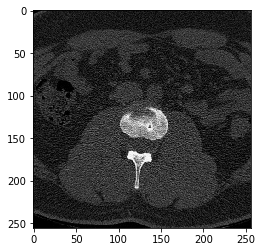

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')

In [24]:
# crf https://github.com/sadeepj/crfasrnn_keras
# c2 64 c2 64 val_loss: 0.0030 - val_acc: 0.9601

# Network

input_img = Input(shape=(size, size, 1))

encoder = Convolution2D(64, (3, 3), padding='same', activation='relu', input_shape=(size,size,1))(input_img)
encoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)

encoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(encoder)
encoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)

code = encoder

#Conv2DTranspose
decoder = UpSampling2D((2,2))(code)
decoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(decoder)
decoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(decoder)

decoder = UpSampling2D((2,2))(decoder)
decoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(decoder)
decoder = Convolution2D(64, (3, 3), padding='same', activation='relu')(decoder)
decoder = Dropout(0.2)(decoder)

decoder = Convolution2D(1, (3, 3), padding='same', activation='relu')(decoder)

output_img = decoder

# model
model = Model(inputs=input_img, outputs=output_img)
print (model.output_shape)

# optimizer
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy'])

#mlogs
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=True, write_images=True)


(None, 256, 256, 1)


In [25]:
# training
model.fit(X_train, Y_train,
                validation_split=0.2,
                epochs=20,
                batch_size=20,
                shuffle=True,
                callbacks=[tensorboard])

"""
Epoch 20/20
60000/60000 [==============================] - 7s - loss: 0.0398
"""


Train on 272 samples, validate on 69 samples
Epoch 1/20
272/272 [==============================] - 4s 16ms/step - loss: 0.0638 - acc: 0.9099 - val_loss: 0.0532 - val_acc: 0.9185
Epoch 2/20
272/272 [==============================] - 4s 16ms/step - loss: 0.0524 - acc: 0.9101 - val_loss: 0.0445 - val_acc: 0.9185
Epoch 3/20
272/272 [==============================] - 4s 16ms/step - loss: 0.0428 - acc: 0.9111 - val_loss: 0.0337 - val_acc: 0.9258
Epoch 4/20
272/272 [==============================] - 4s 16ms/step - loss: 0.0278 - acc: 0.9313 - val_loss: 0.0145 - val_acc: 0.9504
Epoch 5/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0147 - acc: 0.9442 - val_loss: 0.0110 - val_acc: 0.9541
Epoch 6/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0121 - acc: 0.9479 - val_loss: 0.0089 - val_acc: 0.9564
Epoch 7/20
272/272 [==============================] - 4s 15ms/step - loss: 0.0106 - acc: 0.9502 - val_loss: 0.0081 - val_acc: 0.9571
Epoch 8/20
272/272 [====

'\nEpoch 20/20\n60000/60000 [==============================] - 7s - loss: 0.0398\n'

In [26]:
# save
model.save('./save/model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model


(1, 256, 256, 1)


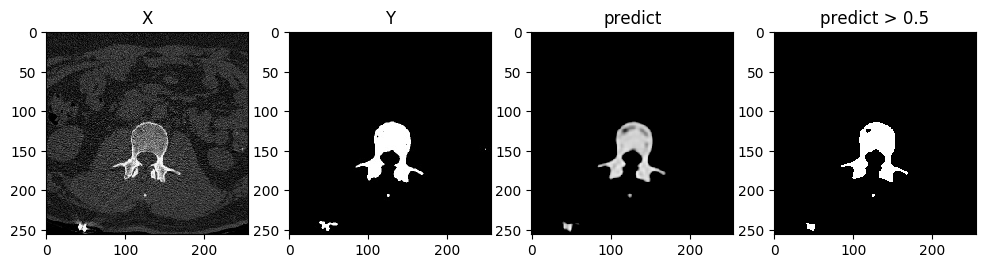

In [31]:
# load
model = load_model('./save/model.h5')
num = 10
X = X_train[num:num+1]
Y = Y_train[num:num+1]
img = model.predict(X)
img2 = img > 0.5
print(img.shape)


plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(141), plt.title('X'), plt.imshow(X.reshape(size,size), cmap='gray')

plt.subplot(142), plt.title('Y'), plt.imshow(Y.reshape(size,size), cmap='gray')

plt.subplot(143), plt.title('predict'), plt.imshow(img.reshape(size,size), cmap='gray')

plt.subplot(144), plt.title('predict > 0.5'), plt.imshow(img2.reshape(size,size), cmap='gray')

plt.show()